## Lab Work 12: Metaheuristics

This notebook builds on the same lecture of Foundations of Machine Learning. We'll focus on Metaheuristics.

Important note: the steps shown here are not always the most efficient or the most "industry-approved." Their main purpose is pedagogical. So don't panic if something looks suboptimal—it's meant to be.

If you have questions (theoretical or practical), don't hesitate to bug your lecturer.

First the necessary imports:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

### Why Metaheuristics in Machine Learning?

Metaheuristics (Simulated Annealing, Genetic Algorithms, Particle Swarm, Ant Colony, etc.) occupy a **fundamental conceptual position in Machine Learning**:

They are the bridge between Statistical Physics, Optimization, Learning from data and Modern foundation models. They answer a central ML question:

> **How can we search an astronomically large hypothesis space when gradients are unreliable, unavailable, or misleading?**

### Optimization as Statistical Mechanics

Most ML problems can be written as:

$
\min_{\theta \in \Theta} \; \mathcal{L}(\theta)
$

which is equivalent to a physical system with:

$
p_T(\theta) \propto e^{-\mathcal{L}(\theta)/T}
$

for low temperature. So, training is equivalent to **cooling a probabilistic system into low-energy configurations**.

Motivation: Modern ML landscapes are Non-convex, Multimodal and Full of flat valleys and barriers

Gradient descent is **local**.  
Metaheuristics are **global**.

Metaheuristics do not assume:

- Differentiability
- Convexity
- Even continuity

They are **learning algorithms without gradients**. Metaheuristics underpin:

| Field                  | Role                       |
| ---------------------- | -------------------------- |
| AutoML                 | architecture search        |
| Diffusion models       | sampling                   |
| Energy-Based Models    | inference                  |
| Reinforcement Learning | policy search              |
| AI for Science         | black-box inverse problems |

They are the **universal optimizer** behind foundation models.

### Final Message

When gradients fail, when models are implicit, when data is scarce,  
**metaheuristics still work.** They are slower and noisy, but universal.


## Traveling Salesman Problem (TSP)

The **Traveling Salesman Problem (TSP)** is one of the fundamental problems of combinatorial optimization.

Given $N$ cities with coordinates

$$
\mathbf{x}_i = (x_i, y_i), \quad i=1,\dots,N,
$$

the goal is to find a permutation $\pi$ minimizing the total tour length:

$$
E(\pi) = \sum_{k=1}^{N}
\left\| \mathbf{x}_{\pi_k} - \mathbf{x}_{\pi_{k+1}} \right\|,
\quad \pi_{N+1}=\pi_1
$$

The TSP is **NP-hard**: the number of possible tours grows as $N!$, making exhaustive search infeasible even for moderate values of $N$.

---


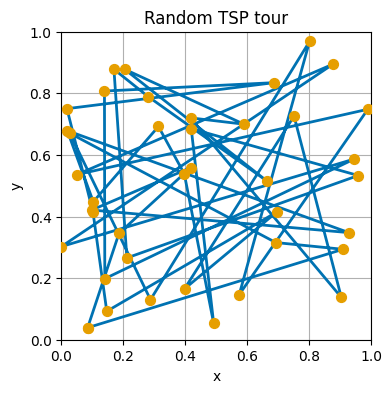

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)
N = 40
cities = np.random.rand(N, 2)

tour = np.random.permutation(N)

pts = cities[tour]
pts = np.vstack([pts, pts[0]])

plt.figure(figsize=(4, 4))

# dark blue lines
plt.plot(pts[:, 0], pts[:, 1], "-", color="#0072B2", linewidth=2)

# orange points
plt.scatter(pts[:, 0], pts[:, 1], s=50, color="#E69F00", zorder=3)

plt.title("Random TSP tour")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

## First Model: Simulated Annealing (SA)

The first model used in this exercise is **Simulated Annealing (SA)**, a metaheuristic inspired by statistical physics.

### Physical Interpretation

- **Configuration**: a tour $\pi$
- **Energy**: $E(\pi)$ = tour length
- **Temperature**: $T$, controls exploration

The system is described by a Gibbs distribution:

$$
p_T(\pi) \propto e^{-E(\pi)/T}
$$

---

## Neighbourhood Proposal: 2-opt Move

At each iteration, a new candidate tour $\pi'$ is generated using a **2-opt move**.

Two positions $i<j$ are chosen uniformly at random and the segment between them is reversed:

$$
\pi = (\dots, a, \underline{b,\dots,c}, d, \dots)
\quad \Rightarrow \quad
\pi' = (\dots, a, \underline{c,\dots,b}, d, \dots)
$$

This move:

- preserves the validity of the tour,
- locally modifies only two edges,
- efficiently explores the space of permutations.

---

## Metropolis Acceptance Rule

Given a candidate tour $\pi'$:

$$
\Delta E = E(\pi') - E(\pi)
$$

$$
P(\pi \to \pi') =
\begin{cases}
1, & \Delta E < 0 \\
e^{-\Delta E/T}, & \Delta E \ge 0
\end{cases}
$$

This rule allows the algorithm to:

- always accept improvements,
- occasionally accept worse solutions,
  enabling escape from local minima.

---

## Cooling Schedule

The temperature decreases geometrically:

$$
T_{k+1} = \alpha T_k, \quad 0<\alpha<1
$$

In the code:

```python
T0, alpha = 1.0, 0.995
T *= alpha
```


In [3]:
np.random.seed(1)
N = 40
cities = np.random.rand(N, 2)


def tour_length(tour):
    return np.sum(np.linalg.norm(cities[tour] - cities[np.roll(tour, -1)], axis=1))


def two_opt(tour):
    i, j = np.sort(np.random.choice(len(tour), 2, replace=False))
    new = tour.copy()
    new[i:j] = new[i:j][::-1]
    return new


T0, alpha, steps = 1.0, 0.995, 4000
tour = np.random.permutation(N)
best = tour.copy()
best_len = tour_length(best)

frames = []
lengths = []
T = T0

for k in range(steps):
    new = two_opt(tour)
    dE = tour_length(new) - tour_length(tour)

    if dE < 0 or np.random.rand() < np.exp(-dE / T):
        tour = new
        if tour_length(tour) < best_len:
            best = tour.copy()
            best_len = tour_length(best)

    T *= alpha
    if k % 20 == 0:
        frames.append(tour.copy())
        lengths.append(best_len)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
(line,) = ax1.plot([], [], "-o")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_title("Tour")

(l2,) = ax2.plot([], [])
ax2.set_xlim(0, len(lengths))
ax2.set_ylim(min(lengths) * 0.9, max(lengths) * 1.1)
ax2.set_title("Best tour length")


def init():
    line.set_data([], [])
    l2.set_data([], [])
    return line, l2


def update(i):
    pts = cities[frames[i]]
    pts = np.vstack([pts, pts[0]])
    line.set_data(pts[:, 0], pts[:, 1])
    l2.set_data(range(i + 1), lengths[: i + 1])
    return line, l2


ani = animation.FuncAnimation(
    fig, update, frames=len(frames), init_func=init, blit=True
)

ani.save("tsp_sa_energy.mp4", fps=10)
plt.close()

## Second Model: Genetic Algorithm (GA) for the TSP

The second metaheuristic used to solve the Traveling Salesman Problem is a **Genetic Algorithm (GA)**.

GAs are inspired by biological evolution and operate on a _population of candidate solutions_ instead of a single configuration.

---

## Population-Based Optimization

Each individual in the population is a tour $\pi$.

The fitness (to be minimized) is the tour length:

$$
E(\pi) = \sum_{k=1}^{N}
\|\mathbf{x}_{\pi_k} - \mathbf{x}_{\pi_{k+1}}\|, \quad \pi_{N+1}=\pi_1
$$

Instead of a single Markov chain, GAs evolve an entire distribution of tours.

---

## Selection (Tournament Selection)

Parents are chosen using **tournament selection**:

From a random subset of $k$ individuals, the one with the smallest energy is selected:

$$
\pi^{(parent)} = \arg\min_{\pi \in \mathcal{C}} E(\pi), \quad \mathcal{C} \subset \text{Population}
$$

This implements a survival-of-the-fittest principle.

---

## Crossover (Recombination)

New tours are created by recombining two parents.

A segment $[i,j]$ from parent $\pi^{(1)}$ is copied into the child; the remaining cities are filled following the order of parent $\pi^{(2)}$:

$$
\pi^{(child)} = \text{Recombine}(\pi^{(1)}, \pi^{(2)})
$$

This preserves partial structures (subtours) and enables inheritance of good building blocks.

---

## Mutation

With probability $p$, two cities are swapped:

$$
\pi \to \pi', \quad p = \text{mutation rate}
$$

Mutation introduces randomness, prevents premature convergence, and ensures exploration.

---

## Generational Dynamics

Each generation creates a new population:

1. Select parents
2. Apply crossover
3. Apply mutation
4. Replace the old population

This defines a stochastic dynamical system in the space of distributions over tours.

---

## Why GA for TSP?

- Explores **many regions simultaneously**
- Recombines partial good solutions
- Very effective for large combinatorial landscapes
- Does not rely on gradients or continuity

GA is a canonical example of an **evolutionary metaheuristic** for combinatorial optimization.

---

## Conceptual Link with Statistical Physics

A GA can be interpreted as a **replicator–mutation dynamics**:

- Selection = energy bias
- Mutation = thermal noise
- Population = probability measure over configurations

In this sense, GAs approximate a non-equilibrium statistical physics process.

This second model highlights the **evolutionary view of learning and optimization**.4

## Genetic Operators Used in This Implementation

This Genetic Algorithm uses problem–specific operators designed for the Traveling Salesman Problem.

---

## Tournament Selection

Parent tours are selected by **tournament selection**.

From a random subset of $k=3$ individuals, the one with minimum tour length is chosen:

$$
\pi^{(parent)} = \arg\min_{\pi \in \mathcal{C}} E(\pi),
\quad \mathcal{C} \subset \text{Population},\ |\mathcal{C}|=3
$$

This implements a local competition mechanism that biases reproduction toward fitter tours while maintaining diversity.

---

## Crossover: Order Crossover (OX)

The algorithm uses a variant of **Order Crossover (OX)**:

1. Choose two cut points $i<j$
2. Copy the segment $\pi^{(1)}_{[i:j]}$ from Parent 1 into the child
3. Fill the remaining positions by scanning Parent 2 in order and inserting the cities that are not yet present

Formally:

$$
\pi^{(child)}_{[i:j]} = \pi^{(1)}_{[i:j]}
$$

$$
\pi^{(child)}_{\text{rest}} = \text{OrderFill}\big(\pi^{(2)}, \pi^{(child)}\big)
$$

This preserves relative ordering and inherits contiguous subtours.

---

## Mutation: Random Swap Mutation

Mutation is implemented as a **swap mutation**:

With probability $p = 0.2$, two positions $i,j$ are chosen uniformly at random and their cities are swapped:

$$
(\pi_i, \pi_j) \rightarrow (\pi_j, \pi_i)
$$

This introduces local random perturbations and prevents premature convergence.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

np.random.seed(1)

N = 40
GENERATIONS = 400
POP = 100
MUTATION_RATE = 0.1

cities = np.random.rand(N, 2)


def tour_length(tour):
    return np.sum(np.linalg.norm(cities[tour] - cities[np.roll(tour, -1)], axis=1))


def select(pop, k=3):
    cand = np.random.choice(len(pop), k, replace=False)
    best = min(cand, key=lambda i: tour_length(pop[i]))
    return pop[best].copy()


def crossover(p1, p2):
    n = len(p1)
    i, j = np.sort(np.random.choice(n, 2, replace=False))
    child = -np.ones(n, dtype=int)
    child[i:j] = p1[i:j]
    fill = [x for x in p2 if x not in child]
    idx = 0
    for k in range(n):
        if child[k] == -1:
            child[k] = fill[idx]
            idx += 1
    return child


def mutate(tour, p=MUTATION_RATE):
    if np.random.rand() < p:
        i, j = np.random.choice(len(tour), 2, replace=False)
        tour[i], tour[j] = tour[j], tour[i]
    return tour


# --- Initial population ---
population = [np.random.permutation(N) for _ in range(POP)]
best_hist = []
mean_hist = []
frames = []

# --- GA ---
for g in range(GENERATIONS):
    new_pop = []
    for _ in range(POP):
        p1 = select(population)
        p2 = select(population)
        child = crossover(p1, p2)
        child = mutate(child)
        new_pop.append(child)
    population = new_pop
    best = min(population, key=tour_length)
    best_hist.append(tour_length(best))
    mean_hist.append(np.mean([tour_length(t) for t in population]))
    if g % 2 == 0:
        frames.append([p.copy() for p in population])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

# Population (left)
lines = [ax1.plot([], [], "-", alpha=0.15, color="#0072B2")[0] for _ in range(POP)]
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_title("Population tours")

# Energy (middle)
(l2,) = ax2.plot([], [], color="black")
ax2.set_xlim(0, GENERATIONS)
ax2.set_ylim(min(best_hist) * 0.95, max(mean_hist) * 1.05)
ax2.set_title("Average tour length")

# Best tour only (right)
(best_line,) = ax3.plot([], [], "-o", color="#E69F00", linewidth=2)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.set_title("Best tour")


def init():
    for line in lines:
        line.set_data([], [])
    l2.set_data([], [])
    best_line.set_data([], [])
    return lines + [l2, best_line]


def update(i):
    pop = frames[i]

    # left panel: whole population
    for k, line in enumerate(lines):
        pts = cities[pop[k]]
        pts = np.vstack([pts, pts[0]])
        line.set_data(pts[:, 0], pts[:, 1])

    # middle panel: mean energy
    l2.set_data(range(i * 2 + 1), mean_hist[: i * 2 + 1])

    # right panel: best tour at this time
    best = min(pop, key=tour_length)
    pts = cities[best]
    pts = np.vstack([pts, pts[0]])
    best_line.set_data(pts[:, 0], pts[:, 1])

    return lines + [l2, best_line]


ani = animation.FuncAnimation(
    fig, update, frames=len(frames), init_func=init, blit=True
)

ani.save("tsp_ga.mp4", fps=10)
plt.close()

# Third Model: Ant Colony Optimization (ACO)

Ant Colony Optimization is a **swarm–reinforcement metaheuristic** inspired by the foraging behavior of real ant colonies.  
Instead of evolving a population of candidate solutions, ACO **constructs solutions probabilistically**, guided by a collective memory stored in a pheromone field over the graph.

Each ant builds a Hamiltonian cycle visiting all cities once, and good tours reinforce themselves through pheromone deposition.

---

## Energy / Fitness Function

Each tour $\pi$ is evaluated by its total length:

$$
E(\pi)=\sum_{k=1}^{N}\|\mathbf{x}_{\pi_k}-\mathbf{x}_{\pi_{k+1}}\|,\quad \pi_{N+1}=\pi_1
$$

The algorithm aims at minimizing $E(\pi)$.

---

## Probabilistic Transition Rule

When an ant is at city $i$, the probability of choosing an unvisited city $j$ is

$$
P(i\to j)=
\frac{\tau_{ij}^{\alpha}\,\eta_{ij}^{\beta}}
{\sum_{k\in\text{unvisited}}\tau_{ik}^{\alpha}\,\eta_{ik}^{\beta}},
\qquad
\eta_{ij}=\frac{1}{d_{ij}}
$$

- $\tau_{ij}$: pheromone level (collective memory)
- $\eta_{ij}$: heuristic visibility (short edges are favored)
- $\alpha$: controls memory exploitation
- $\beta$: controls greedy pressure

This implements a **stochastic greedy construction** of tours.

---

## Pheromone Update

After all ants build their tours:

**Evaporation**:

$$
\tau_{ij} \leftarrow (1-\rho)\,\tau_{ij}
$$

**Reinforcement**:

$$
\tau_{ij} \leftarrow \tau_{ij} + \frac{Q}{E(\pi)}
$$

Short tours deposit more pheromone, producing a **self-reinforcing collective learning process**.

---

## Interpretation

ACO performs optimization by **reinforcement-biased sampling in permutation space**.  
The graph itself acts as a distributed memory storing what the colony has learned about good routes.

> _GA evolves solutions, PSO moves solutions, ACO teaches the graph how to build solutions._


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

np.random.seed(1)

# ============================
# Parameters
# ============================
N = 40
ANTS = 200
GENERATIONS = 300
ALPHA = 1.0
BETA = 1.0
EVAPORATION = 0.5
Q = 1.0

# ============================
# Cities
# ============================
cities = np.random.rand(N, 2)
dist_matrix = np.linalg.norm(cities[:, None, :] - cities[None, :, :], axis=2)
eta = 1 / dist_matrix
np.fill_diagonal(eta, 0)

# ============================
# Pheromones
# ============================
tau = np.ones((N, N))


# ============================
# Functions
# ============================
def tour_length(tour):
    return np.sum(dist_matrix[tour, np.roll(tour, -1)])


def choose_next_city(current, unvisited, tau, eta):
    prob = (tau[current, unvisited] ** ALPHA) * (eta[current, unvisited] ** BETA)
    prob /= prob.sum()
    return np.random.choice(unvisited, p=prob)


# ============================
# ACO
# ============================
best_length = np.inf
best_tour = None
length_history = []

frames = []
best_frames = []

for g in range(GENERATIONS):
    tours = []

    for ant in range(ANTS):
        start = np.random.randint(N)
        tour = [start]
        unvisited = list(range(N))
        unvisited.remove(start)

        while unvisited:
            nxt = choose_next_city(tour[-1], np.array(unvisited), tau, eta)
            tour.append(nxt)
            unvisited.remove(nxt)

        tours.append(np.array(tour))

    # Evaporation
    tau *= 1 - EVAPORATION

    # Deposit pheromones
    for tour in tours:
        L = tour_length(tour)
        for i in range(N):
            tau[tour[i], tour[(i + 1) % N]] += Q / L

    # Track best
    lengths = [tour_length(t) for t in tours]
    best_idx = np.argmin(lengths)
    if lengths[best_idx] < best_length:
        best_length = lengths[best_idx]
        best_tour = tours[best_idx].copy()

    length_history.append(np.mean(lengths))

    if g % 2 == 0:
        frames.append([t.copy() for t in tours])
        best_frames.append(best_tour.copy())

# ============================
# Animation
# ============================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

# Left: ants
lines = [ax1.plot([], [], "-", alpha=0.12, color="#0072B2")[0] for _ in range(ANTS)]
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_title("Ant tours")

# Middle: energy
(l2,) = ax2.plot([], [], color="black")
ax2.set_xlim(0, GENERATIONS)
ax2.set_ylim(min(length_history) * 0.95, max(length_history) * 1.05)
ax2.set_title("Average tour length")

# Right: best tour
(best_line,) = ax3.plot([], [], "-o", color="#E69F00", linewidth=2)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.set_title("Best tour")


def init():
    for line in lines:
        line.set_data([], [])
    l2.set_data([], [])
    best_line.set_data([], [])
    return lines + [l2, best_line]


def update(i):
    pop = frames[i]

    # all ants
    for k, line in enumerate(lines):
        pts = cities[pop[k]]
        pts = np.vstack([pts, pts[0]])
        line.set_data(pts[:, 0], pts[:, 1])

    # energy evolution
    l2.set_data(range(i * 2 + 1), length_history[: i * 2 + 1])

    # best tour
    best = best_frames[i]
    pts = cities[best]
    pts = np.vstack([pts, pts[0]])
    best_line.set_data(pts[:, 0], pts[:, 1])

    return lines + [l2, best_line]


ani = animation.FuncAnimation(
    fig, update, frames=len(frames), init_func=init, blit=True
)
ani.save("tsp_aco.mp4", fps=10)
plt.close()

/var/folders/nd/jw9h_5215q3cx8t5kjj7fyg40000gn/T/ipykernel_95394/1285320904.py:23: RuntimeWarning: divide by zero encountered in divide
  eta = 1 / dist_matrix


## Fourth Model: Particle Swarm Optimization (PSO) for the TSP

The third metaheuristic used to solve the Traveling Salesman Problem is
**Particle Swarm Optimization (PSO)**.

PSO is inspired by the collective behavior of swarms (birds, fish, insects) and
models optimization as a process of **social self-organization**.

---

## Swarm Representation

Each particle is a tour $\pi$.

- Personal best: $p^{best}_i$ = best tour ever found by particle $i$
- Global best: $g^{best}$ = best tour found by the entire swarm

The swarm evolves through stochastic attraction toward both personal memory and social consensus.

---

## Fitness Function

The energy minimized by PSO is the tour length:

$$
E(\pi) = \sum_{k=1}^{N}
\|\mathbf{x}_{\pi_k} - \mathbf{x}_{\pi_{k+1}}\|, \quad \pi_{N+1}=\pi_1
$$

---

## Discrete Velocity via Swap Sequences (with Example)

In continuous PSO, velocity is a vector in $\mathbb{R}^d$.
For the TSP, particles live in the permutation space $\mathcal{S}_N$, so velocity must be defined **combinatorially**.

A discrete velocity is represented as a **swap sequence**: a list of transpositions that transform one tour into another.

---

### Example: Computing a Velocity

Suppose a particle has current tour:

$$
\pi = [1,2,3,4,5]
$$

and wants to move toward its personal best:

$$
p^{best} = [1,3,2,5,4]
$$

We compute the minimal swap sequence that transforms $\pi$ into $p^{best}$:

| Step | Swap    | Result        |
| ---- | ------- | ------------- |
| —    | —       | $[1,2,3,4,5]$ |
| 1    | $(2,3)$ | $[1,3,2,4,5]$ |
| 2    | $(4,5)$ | $[1,3,2,5,4]$ |

So the discrete velocity is:

$$
S_{p^{best}} = \{(2,3),(4,5)\}
$$

---

### Probabilistic Application (Velocity Scaling)

In continuous PSO, velocity is scaled by real coefficients.
In discrete PSO, we **apply only a fraction of the swaps**.

Let:

$$
S = \{(i_1,j_1), (i_2,j_2), \dots, (i_m,j_m)\}
$$

Then

$$
\text{Apply}(S, p)
$$

means:

- For each swap $(i_k,j_k)$, apply it with probability $p$.
- Different swaps are applied independently.

Example:

If

$$
S_{p^{best}} = \{(2,3),(4,5)\}
$$

and $p = 0.5$, possible outcomes are:

| Outcome      | Probability | Result        |
| ------------ | ----------- | ------------- |
| No swaps     | $0.25$      | $[1,2,3,4,5]$ |
| Only $(2,3)$ | $0.25$      | $[1,3,2,4,5]$ |
| Only $(4,5)$ | $0.25$      | $[1,2,3,5,4]$ |
| Both         | $0.25$      | $[1,3,2,5,4]$ |

Thus the particle moves _partially_ toward its attractor — exactly like scaling a velocity vector.

---

### Cognitive + Social Motion

The particle update rule becomes:

$$
\pi \leftarrow \text{Apply}(S_{p^{best}}, C_1/2)
$$

$$
\pi \leftarrow \text{Apply}(S_{g^{best}}, C_2/2)
$$

so each particle performs a **randomized convex combination of permutations**,
creating a self-organized drift toward consensus.

---

### Physical Interpretation

This is a discrete analogue of:

$$
v_{t+1} = C_1 r_1 (p^{best}-x_t) + C_2 r_2 (g^{best}-x_t)
$$

but lifted from Euclidean space to the symmetric group $\mathcal{S}_N$.

The swarm literally _flows in permutation space_.

---

## Random Mutation

With probability $p_m$ two cities are randomly swapped:

$$
(\pi_i, \pi_j) \rightarrow (\pi_j, \pi_i)
$$

This introduces exploration and prevents swarm collapse.

---

## Embedded Local Search (2-opt)

Every $k$ generations the best particle is refined by a **2-opt local search**:

$$
g^{best} \leftarrow \text{2-opt}(g^{best})
$$

This hybridizes PSO with deterministic descent, greatly improving convergence.

---

## Why PSO for TSP?

- Models collective intelligence
- Shares information globally
- Fast convergence
- Excellent balance between exploration and exploitation

PSO is a canonical example of a **self-organizing metaheuristic**.

---

## Unified Interpretation

| Algorithm | Physical Interpretation          |
| --------- | -------------------------------- |
| SA        | Thermodynamic relaxation         |
| GA        | Evolutionary dynamics            |
| PSO       | Self-organized collective motion |

Together, they illustrate the three fundamental paradigms of modern metaheuristic learning.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

np.random.seed(1)

# --- Parametri ---
N = 40  # città
PARTICLES = 20  # particelle
GENERATIONS = 400
C1 = 1.5  # cognitive
C2 = 0.2  # social
MUTATION_PROB = 0.1  # mutazione casuale
TWO_OPT_FREQ = 5  # applica 2-opt ogni X generazioni

# --- Città ---
cities = np.random.rand(N, 2)
dist_matrix = np.linalg.norm(cities[:, None, :] - cities[None, :, :], axis=2)


# --- Funzioni ---
def tour_length(tour):
    return np.sum(dist_matrix[tour, np.roll(tour, -1)])


def swap_sequence(a, b):
    """Sequenza di swap per trasformare a in b"""
    a = list(a)
    swaps = []
    for i in range(len(a)):
        if a[i] != b[i]:
            j = a.index(b[i])
            swaps.append((i, j))
            a[i], a[j] = a[j], a[i]
    return swaps


def apply_swaps(tour, swaps, prob=0.5):
    tour = tour.copy()
    for i, j in swaps:
        if np.random.rand() < prob:
            tour[i], tour[j] = tour[j], tour[i]
    return tour


def two_opt(tour):
    best = tour.copy()
    improved = True
    while improved:
        improved = False
        for i in range(1, len(tour) - 2):
            for j in range(i + 1, len(tour)):
                new = best.copy()
                new[i:j] = best[i:j][::-1]
                if tour_length(new) < tour_length(best):
                    best = new
                    improved = True
    return best


# --- Inizializzazione ---
population = [np.random.permutation(N) for _ in range(PARTICLES)]
pbest = population.copy()
pbest_scores = [tour_length(t) for t in population]
gbest_idx = np.argmin(pbest_scores)
gbest = pbest[gbest_idx].copy()
gbest_score = pbest_scores[gbest_idx]

frames = []
mean_hist = []

# --- PSO loop ---
for g in range(GENERATIONS):
    new_pop = []
    for i in range(PARTICLES):
        # Cognitive e social
        swaps_c = swap_sequence(population[i], pbest[i])
        swaps_s = swap_sequence(population[i], gbest)
        tour = apply_swaps(population[i], swaps_c, prob=C1 / 2)
        tour = apply_swaps(tour, swaps_s, prob=C2 / 2)
        # Mutazione casuale
        if np.random.rand() < MUTATION_PROB:
            a, b = np.random.choice(N, 2, replace=False)
            tour[a], tour[b] = tour[b], tour[a]
        new_pop.append(tour)
        score = tour_length(tour)
        if score < pbest_scores[i]:
            pbest[i] = tour.copy()
            pbest_scores[i] = score
    population = new_pop
    # Aggiorna gbest
    gbest_idx = np.argmin(pbest_scores)
    gbest = pbest[gbest_idx].copy()
    gbest_score = pbest_scores[gbest_idx]
    # 2-opt sul miglior tour ogni TWO_OPT_FREQ generazioni
    if g % TWO_OPT_FREQ == 0:
        gbest = two_opt(gbest)
        pbest[gbest_idx] = gbest.copy()
        pbest_scores[gbest_idx] = tour_length(gbest)
    # Storico per grafico
    mean_hist.append(np.mean([tour_length(t) for t in population]))
    if g % 2 == 0:
        frames.append([p.copy() for p in population])

# --- Animazione ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

# Left: swarm / particles
lines = [
    ax1.plot([], [], "-", alpha=0.15, color="#0072B2")[0] for _ in range(PARTICLES)
]
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_title("Particle tours")

# Middle: energy evolution
(l2,) = ax2.plot([], [], color="black")
ax2.set_xlim(0, GENERATIONS)
ax2.set_ylim(min(mean_hist) * 0.95, max(mean_hist) * 1.05)
ax2.set_title("Average tour length")

# Right: best particle only
(best_line,) = ax3.plot([], [], "-o", color="#E69F00", linewidth=2)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.set_title("Best tour")


def init():
    for line in lines:
        line.set_data([], [])
    l2.set_data([], [])
    best_line.set_data([], [])
    return lines + [l2, best_line]


def update(i):
    pop = frames[i]

    # left panel: all particles
    for k, line in enumerate(lines):
        pts = cities[pop[k]]
        pts = np.vstack([pts, pts[0]])
        line.set_data(pts[:, 0], pts[:, 1])

    # middle panel: average energy
    l2.set_data(range(i * 2 + 1), mean_hist[: i * 2 + 1])

    # right panel: best particle of this step
    best = min(pop, key=tour_length)
    pts = cities[best]
    pts = np.vstack([pts, pts[0]])
    best_line.set_data(pts[:, 0], pts[:, 1])

    return lines + [l2, best_line]


ani = animation.FuncAnimation(
    fig, update, frames=len(frames), init_func=init, blit=True
)

ani.save("tsp_pso_optimized.mp4", fps=10)
plt.close()